<a href="https://colab.research.google.com/github/hikaru122700/kaggle-pub/blob/GCI-%E3%82%B3%E3%83%B3%E3%83%9A%EF%BC%92-Home-Credit/021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [3]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from itertools import combinations
import gc

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import log_loss
import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:

# すべての列を表示するように設定
pd.set_option('display.max_columns', None)


必要なデータの読み込みを行います。GCIの教材フォルダの構成を想定して、読み込んでいます。

In [5]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。

path  = "/content/drive/My Drive/松尾研/GCI/コンペ２/"

train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
sample_sub = pd.read_csv(path + "sample_submission.csv")

## 1. データの可視化と分析

### 1.1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

In [6]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 51)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


In [7]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 50)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,171202,Cash loans,F,N,N,1,144000.0,961146.0,28233.0,688500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.025164,-12108,-2372,-2446.0,-3022,NaN,1,1,0,1,1,0,Medicine staff,3.0,2,2,0,0,0,0,0,0,Kindergarten,NaN,0.720416,NaN,2.0,0.0,2.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,171203,Cash loans,F,N,N,0,103500.0,296280.0,16069.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.007020,-17907,-1712,-10450.0,-253,NaN,1,1,1,1,0,0,Cleaning staff,2.0,2,2,0,0,0,0,0,0,School,NaN,0.287306,NaN,5.0,0.0,5.0,0.0,-212.0,NaN,NaN,NaN,NaN
2,171204,Cash loans,F,N,Y,1,180000.0,183694.5,11236.5,139500.0,Children,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.006852,-15221,-553,-1056.0,-4495,NaN,1,1,0,1,0,0,NaN,2.0,3,3,0,0,0,1,1,0,Trade: type 7,NaN,0.352456,0.389339,7.0,0.0,7.0,0.0,-428.0,0.0,1.0,1.0,1.0


In [8]:
# train["bb"].describe()

In [9]:
all_df = pd.concat([train, test], axis=0)
all_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
all_df.drop("SK_ID_CURR", axis=1, inplace=True)


In [10]:
all_df.head(3)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878.0,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,0.0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,NaN,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,0.0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523.0,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


In [11]:
all_df["DAYS_EMPLOYED"].describe()

,DAYS_EMPLOYED
count,191239.000000
mean,-2368.321796
std,2330.008077
min,-17912.000000
25%,-3160.000000
50%,-1634.000000
75%,-759.000000
max,0.000000


In [12]:
# 各種商（比率）特徴量
all_df['CREDIT_INCOME_RATIO'] = all_df['AMT_CREDIT'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6)   # クレジット額 / 総収入
all_df['CREDIT_ANNUITY_RATIO'] = all_df['AMT_CREDIT'] / (all_df['AMT_ANNUITY'] + 1e-6)       # クレジット額 / 年金返済額
all_df['CREDIT_GOODS_RATIO'] = all_df['AMT_CREDIT'] / (all_df['AMT_GOODS_PRICE'] + 1e-6)     # クレジット額 / 商品価格
all_df['ANNUITY_INCOME_RATIO'] = all_df['AMT_ANNUITY'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6) # 年金返済額 / 総収入
all_df['GOODS_INCOME_RATIO'] = all_df['AMT_GOODS_PRICE'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6) # 商品価格 / 総収入
all_df['ANNUITY_GOODS_RATIO'] = all_df['AMT_ANNUITY'] / (all_df['AMT_GOODS_PRICE'] + 1e-6)   # 年金返済額 / 商品価格
all_df['EMPLOYED_BIRTH_RATIO'] = all_df['DAYS_EMPLOYED'] / (all_df['DAYS_BIRTH'] + 1e-6)     # 就業日数 / 年齢（日）

# 新たな商（比率）特徴量の追加
all_df['DAYS_EMPLOYED_PERC'] = all_df['DAYS_EMPLOYED'] / (all_df['DAYS_BIRTH'] + 1e-6)      # 雇用日数 / 出生日数
all_df['INCOME_CREDIT_PERC'] = all_df['AMT_INCOME_TOTAL'] / (all_df['AMT_CREDIT'] + 1e-6)  # 総収入 / クレジット額
all_df['INCOME_PER_PERSON'] = all_df['AMT_INCOME_TOTAL'] / (all_df['CNT_FAM_MEMBERS'] + 1e-6) # 総収入 / 家族人数
all_df['ANNUITY_INCOME_PERC'] = all_df['AMT_ANNUITY'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6) # 年金額 / 総収入
all_df['PAYMENT_RATE'] = all_df['AMT_ANNUITY'] / (all_df['AMT_CREDIT'] + 1e-6)            # 年金額 / クレジット額

# 各種積（プロダクト）特徴量
all_df['CREDIT_INCOME_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['AMT_INCOME_TOTAL']           # クレジット額 × 総収入
all_df['CREDIT_ANNUITY_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['AMT_ANNUITY']               # クレジット額 × 年金返済額
all_df['CREDIT_GOODS_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['AMT_GOODS_PRICE']             # クレジット額 × 商品価格
all_df['INCOME_ANNUITY_PRODUCT'] = all_df['AMT_INCOME_TOTAL'] * all_df['AMT_ANNUITY']         # 総収入 × 年金返済額
all_df['INCOME_GOODS_PRODUCT'] = all_df['AMT_INCOME_TOTAL'] * all_df['AMT_GOODS_PRICE']       # 総収入 × 商品価格
all_df['ANNUITY_GOODS_PRODUCT'] = all_df['AMT_ANNUITY'] * all_df['AMT_GOODS_PRICE']           # 年金返済額 × 商品価格

# DAYS_BIRTH, DAYS_EMPLOYEDを用いた積
# 日数の符号は負となるが、そのまま特徴として使うことで就業期間と年齢関係を非線形的に捉えられる可能性がある
all_df['EMPLOYED_BIRTH_PRODUCT'] = all_df['DAYS_EMPLOYED'] * all_df['DAYS_BIRTH']            # 就業日数 × 年齢（日）

# EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3との組み合わせ特徴量
# EXT_SOURCE_xが存在する場合にのみ処理を実行
for i in range(1, 4):
    ext_source_col = f'EXT_SOURCE_{i}'
    if ext_source_col in all_df.columns:
        all_df[f'CREDIT_EXT_SOURCE_{i}_RATIO'] = all_df['AMT_CREDIT'] / (all_df[ext_source_col] + 1e-6)
        all_df[f'INCOME_EXT_SOURCE_{i}_RATIO'] = all_df['AMT_INCOME_TOTAL'] / (all_df[ext_source_col] + 1e-6)
        all_df[f'CREDIT_EXT_SOURCE_{i}_PRODUCT'] = all_df['AMT_CREDIT'] * all_df[ext_source_col]
        all_df[f'INCOME_EXT_SOURCE_{i}_PRODUCT'] = all_df['AMT_INCOME_TOTAL'] * all_df[ext_source_col]

# 必要に応じて、他の日数系特徴量（DAYS_REGISTRATION, DAYS_ID_PUBLISHなど）との組み合わせや、
# 他の数値特徴量との積・商も追加で生成できます。

# 例として、DAYS_REGISTRATIONとAMT_CREDITの組み合わせを追加する場合：
if 'DAYS_REGISTRATION' in all_df.columns:
    all_df['CREDIT_REGISTRATION_RATIO'] = all_df['AMT_CREDIT'] / (all_df['DAYS_REGISTRATION'].abs() + 1e-6)
    all_df['CREDIT_REGISTRATION_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['DAYS_REGISTRATION']


In [13]:
all_df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT
0,0.0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878.0,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN,6.712800,20.787811,1.118800,0.322920,6.000000,0.053820,0.095094,0.095094,0.148969,56249.971875,0.322920,0.048105,8.495888e+10,2.743492e+10,5.097532e+11,4.086956e+09,7.593750e+10,2.452174e+10,8106574.0,NaN,NaN,NaN,NaN,2.026857e+06,3.019391e+05,281376.735276,41916.448468,NaN,NaN,NaN,NaN,2267.837831,-2.514783e+08
1,0.0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,NaN,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0,2.600000,34.629728,1.000000,0.075080,2.600000,0.028877,NaN,NaN,0.384615,112499.943750,0.075080,0.028877,1.316250e+11,9.882405e+09,3.422250e+11,3.800925e+09,1.316250e+11,9.882405e+09,NaN,NaN,NaN,NaN,NaN,1.301249e+06,5.004806e+05,262996.646938,101152.556515,1.057549e+06,4.067497e+05,323601.348781,124462.057223,130.901768,-2.614365e+09
2,0.0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523.0,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN,6.188000,18.303180,1.237600,0.338083,5.000000,0.067617,0.028276,0.028276,0.161603,26999.986500,0.338083,0.054635,1.804421e+10,6.100446e+09,9.022104e+10,9.858510e+08,1.458000e+10,4.929255e+09,9673408.0,NaN,NaN,NaN,NaN,5.867418e+05,9.481929e+04,190300.683015,30753.180836,NaN,NaN,NaN,NaN,91.800000,-1.216313e+09
3,0.0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,NaN,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.264000,17.168857,1.132000,0.131867,2.000000,0.065933,NaN,NaN,0.441696,67499.932500,0.131867,0.058245,1.031535e+10,1.360251e+09,2.063070e+10,6.008175e+08,9.112500e+09,1.201635e+09,NaN,NaN,NaN,NaN,NaN,1.452170e+06,6.414180e+05,16081.949503,7103.334586,1.991078e+05,8.7945

In [14]:
all_df = pd.get_dummies(all_df, dummy_na=True)



In [15]:
all_df

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: t

In [16]:
# 閾値の設定
threshold = 0.9

# 相関行列の計算（絶対値）
corr_matrix = all_df.corr().abs()

# 相関行列の上三角部分のみを抽出
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 閾値を超える相関を持つ列を特定
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# 削除する列数を表示
print('削除する列の数: %d' % len(to_drop))

# 相関の高い列を削除
all_df = all_df.drop(columns=to_drop)  # all_df からも削除

# データセットの形状を表示
print('All data shape: ', all_df.shape)  # all_df の形状を表示

削除する列の数: 22
All data shape:  (232702, 178)


In [17]:
# Train missing values (in percent)
all_df_missing = (all_df.isnull().sum() / len(all_df)).sort_values(ascending = False)
all_df_missing.head()
# 閾値を超える欠損値を持つ列を特定
all_df_missing = all_df_missing.index[all_df_missing > 0.75]

print('There are %d columns with more than 75%% missing values' % len(all_df_missing))
all_df = pd.get_dummies(all_df.drop(columns = all_df_missing))

There are 0 columns with more than 75% missing values


In [18]:
# 特殊文字を含むカラム名を検出
import re

special_chars = r'["\\/\b\f\n\r\t]'
invalid_columns = [col for col in all_df.columns if re.search(special_chars, col)]
print("特殊文字を含むカラム:", invalid_columns)

# 特殊文字をアンダースコアに置換
all_df.columns = [re.sub(special_chars, '_', col) for col in all_df.columns]
all_df.columns = [re.sub(special_chars, '_', col) for col in all_df.columns]


特殊文字を含むカラム: ['NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_HOUSING_TYPE_House / apartment', 'OCCUPATION_TYPE_Waiters/barmen staff']


In [19]:
train = all_df[:train.shape[0]]
test = all_df[train.shape[0]:]

In [20]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 178)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary _ secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single _ not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House _ apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters_barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,O

In [21]:
train["TARGET"].value_counts()

,count
TARGET,
0.0,157381
1.0,13821


In [22]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 178)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary _ secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single _ not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House _ apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters_barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,O

In [23]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary _ secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single _ not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House _ apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters_barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,O

In [24]:
test

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary _ secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single _ not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House _ apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters_barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,O

In [25]:
test.drop("TARGET", axis=1, inplace=True)

In [26]:
# 目的変数と説明変数に分割
train_x = train.drop("TARGET", axis=1)
train_y = train["TARGET"]
test_x = test

In [27]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# 列名をサニタイズする関数
def sanitize_column_names(columns):
    sanitized = []
    for col in columns:
        # アルファベット、数字、アンダースコア以外の文字をアンダースコアに置換
        new_col = re.sub(r'[^\w]', '_', col)
        # 先頭が数字の場合、アンダースコアを追加
        if re.match(r'^\d', new_col):
            new_col = '_' + new_col
        sanitized.append(new_col)
    return sanitized

# 列名を修正
train.columns = sanitize_column_names(train.columns)
test.columns = sanitize_column_names(test.columns)
# 特徴重要度を格納するための空の配列を初期化
feature_importances = np.zeros(train.drop("TARGET", axis=1).shape[1])
# モデルの定義
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',           # 'goss'ではなく'gbdt'に設定
    data_sample_strategy='goss',    # 'goss'を明示的に指定
    n_estimators=1000,
    class_weight='balanced',
    verbose=0                       # コンストラクタ内でのverbose設定（例: 情報レベル）
)


# 過学習を避けるためにモデルを2回フィット
for i in range(2):
    # トレーニングセットとバリデーションセットに分割
    train_features, valid_features, train_y, valid_y = train_test_split(
        train.drop("TARGET", axis=1), train["TARGET"], test_size=0.25, random_state=i
    )

    # アーリーストッピングを使用してモデルをトレーニング
    model.fit(
        train_features, train_y,
        eval_set=[(valid_features, valid_y)],
        eval_metric='auc',
    )

    # 特徴重要度を記録
    feature_importances += model.feature_importances_

# 特徴重要度の平均を計算
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({
    'feature': list(train.drop("TARGET", axis=1).columns),
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# 上位の特徴を表示
print(feature_importances.head())


                   feature  importance
6            DAYS_EMPLOYED      1556.5
8          DAYS_ID_PUBLISH      1246.5
30  DAYS_LAST_PHONE_CHANGE      1238.0
5               DAYS_BIRTH      1207.5
25            EXT_SOURCE_2      1064.5


In [28]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('重要度が0.0の特徴量は %d 個あります' % len(zero_features))
print(feature_importances.tail())

重要度が0.0の特徴量は 21 個あります
                              feature  importance
79               NAME_INCOME_TYPE_nan         0.0
77        NAME_INCOME_TYPE_Unemployed         0.0
76           NAME_INCOME_TYPE_Student         0.0
74   NAME_INCOME_TYPE_Maternity_leave         0.0
176             ORGANIZATION_TYPE_nan         0.0


In [29]:
# 重要度が0の特徴量を削除
train = train.drop(columns=zero_features)
test = test.drop(columns=zero_features)

print('トレーニングデータの形状: ', train.shape)
print('テストデータの形状: ', test.shape)

トレーニングデータの形状:  (171202, 157)
テストデータの形状:  (61500, 156)


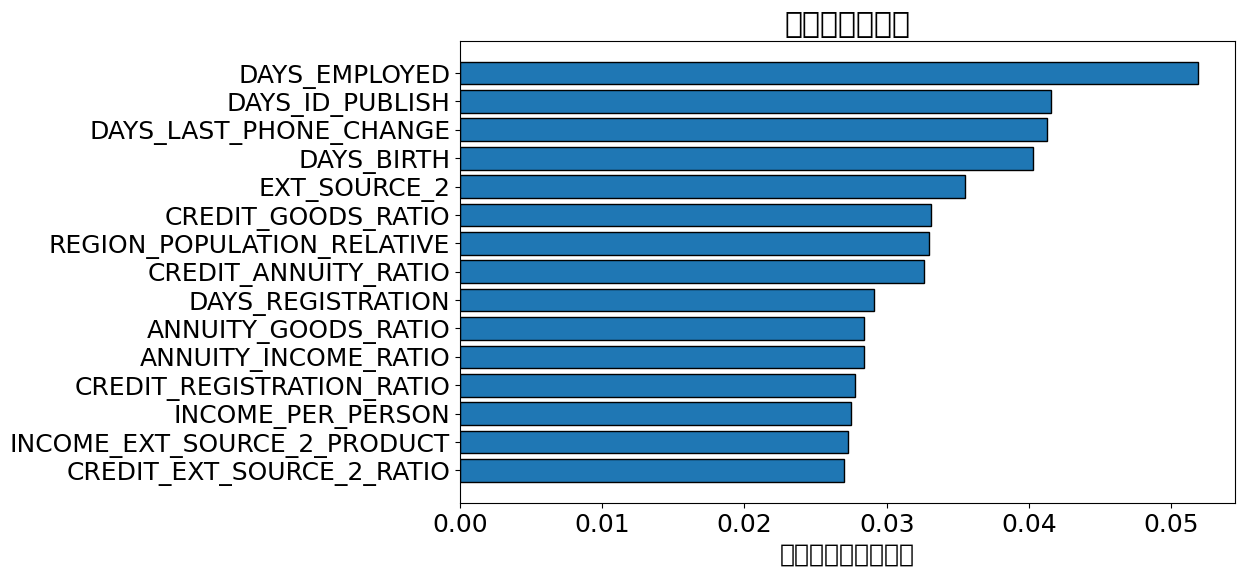

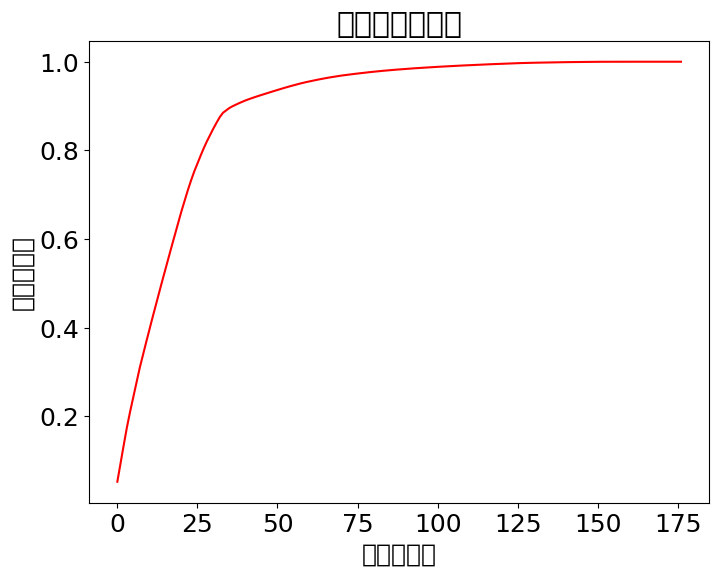

38 個の特徴量で累積重要度 0.90 を達成


In [30]:
def plot_feature_importances(df, threshold=0.9):
    """
    15個の最も重要な特徴量と特徴量の累積重要度をプロットします。
    累積重要度が閾値に達するために必要な特徴量の数を表示します。

    パラメータ
    --------
    df : DataFrame
        特徴量の重要度を含むデータフレーム。'feature'と'importance'列が必要。
    threshold : float, default=0.9
        累積重要度の閾値。

    戻り値
    --------
    df : DataFrame
        正規化された重要度と累積重要度を含むデータフレーム。
    """

    plt.rcParams['font.size'] = 18

    # 重要度に基づいて特徴量をソート
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # 重要度を正規化
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # 重要度上位15個の水平棒グラフ
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # 上位15個を逆順にしてプロット
    ax.barh(
        list(reversed(list(df.index[:15]))),
        df['importance_normalized'].head(15),
        align='center',
        edgecolor='k'
    )

    # y軸のラベル設定
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # ラベルとタイトル
    plt.xlabel('正規化された重要度')
    plt.title('特徴量の重要度')
    plt.show()

    # 累積重要度の折れ線グラフ
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('特徴量の数')
    plt.ylabel('累積重要度')
    plt.title('累積特徴重要度')
    plt.show()

    # 累積重要度が閾値を超える最小の特徴量数を取得
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d 個の特徴量で累積重要度 %0.2f を達成' % (importance_index + 1, threshold))

    return df

# 特徴重要度をプロットし、正規化されたデータフレームを取得
norm_feature_importances = plot_feature_importances(feature_importances)

In [31]:
def identify_zero_importance_features(train, train_labels, iterations=2):
    """
    勾配ブースティングモデルに基づいて、トレーニングデータセットの0重要度特徴量を特定します。

    パラメータ
    --------
    train : DataFrame
        トレーニング特徴量
    train_labels : Seriesまたはarray-like
        トレーニングデータのラベル
    iterations : int, default=2
        特徴重要度を決定するためのクロスバリデーションの反復回数

    戻り値
    --------
    zero_features : list
        重要度が0の特徴量のリスト
    feature_importances : DataFrame
        各特徴量の重要度を含むデータフレーム
    """

    # 特徴重要度を格納するための空の配列を初期化
    feature_importances = np.zeros(train.shape[1])

    # モデルを作成
    model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',           # 'goss'ではなく'gbdt'に設定
    data_sample_strategy='goss',    # 'goss'を明示的に指定
    n_estimators=1000,
    class_weight='balanced',
    verbose=0                       # コンストラクタ内でのverbose設定（例: 情報レベル）
    )

    # 複数回モデルをフィットして特徴重要度を記録
    for i in range(iterations):
        # トレーニングセットとバリデーションセットに分割
        train_features, valid_features, train_y, valid_y = train_test_split(
            train, train_labels, test_size=0.25, random_state=i
        )

        # アーリーストッピングを使用してモデルをトレーニング
        model.fit(
        train_features, train_y,
        eval_set=[(valid_features, valid_y)],
        eval_metric='auc',
    )

        # 特徴重要度を記録
        feature_importances += model.feature_importances_ / iterations

    # 特徴重要度をデータフレームに変換
    feature_importances = pd.DataFrame({
        'feature': list(train.columns),
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    # 重要度が0の特徴量を特定
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\n重要度が0.0の特徴量は %d 個あります' % len(zero_features))

    return zero_features, feature_importances

# 再度特徴重要度を確認
second_round_zero_features, feature_importances = identify_zero_importance_features(train.drop("TARGET", axis=1), train["TARGET"])



重要度が0.0の特徴量は 0 個あります


In [32]:

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import numpy as np
import gc
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBClassifier
        params1 = {
            'n_estimators': 625,
            'max_depth': 3,
            'learning_rate': 0.051151683110662566,
            'reg_alpha': 2.5636916289607576,
            'reg_lambda': 6.894373540615878,
            'subsample': 0.7499584583311859,
            'colsample_bytree': 0.7769338267922302,
            'gamma': 3.6778063980918563,
            'min_child_weight': 4
        }
        model1 = XGBClassifier(**params1)

        # モデル2: CatBoostClassifier
        params2 = {
            'iterations': 931,
            'depth': 5,
            'learning_rate': 0.0397506489890301,
            'l2_leaf_reg': 7.259805012462418,
            'border_count': 228,
            'subsample': 0.5378073376548962,
            'colsample_bylevel': 0.7560402476055218,
            'random_strength': 5.930979110691442,
            'bagging_temperature': 0.16161978611186564,
            "random_state": 13,
            "verbose": 0
        }
        model2 = CatBoostClassifier(**params2)

        # モデル3: XGBClassifier
        params3 = {
            'n_estimators': 775,
            'max_depth': 4,
            'learning_rate': 0.059967058989802736,
            'reg_alpha': 4.252608756868103,
            'reg_lambda': 6.872086297579257,
            'subsample': 0.7146820344108187,
            'colsample_bytree': 0.7295963801421386,
            'gamma': 3.9044476288195145,
            'min_child_weight': 10
        }
        model3 = XGBClassifier(**params3)

        # モデル4: CatBoostClassifier
        params4 = {
           'iterations': 764,
           'depth': 3,
           'learning_rate': 0.04793616966551865,
           'l2_leaf_reg': 0.5732774089373636,
           'border_count': 219,
           'subsample': 0.689933616411996,
           'colsample_bylevel': 0.7647590031166003,
           'random_strength': 7.082062509789765,
           'bagging_temperature': 0.33990581477435816,
            'random_state': 42
        }
        model4 = CatBoostClassifier(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict_proba(X_valid)[:, 1]
            auc = roc_auc_score(y_valid, preds)
            print(f"Fold {fold + 1} AUC for {name} = {auc}")
            loss_dict[(name,)] = auc  # キーをタプルに変更
            valid_pred_dict[(name,)] = preds
            sum_error[(name,)] += auc

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[(comb_part,)] for comb_part in comb], axis=0)
                auc_comb = roc_auc_score(y_valid, preds_comb)
                print(f"Fold {fold + 1} AUC for {comb} = {auc_comb}")
                loss_dict[comb] = auc_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += auc_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[(model,)] for model in model_names], axis=0)
        auc_all = roc_auc_score(y_valid, preds_all)
        print(f"Fold {fold + 1} AUC for all models ensemble = {auc_all}")
        loss_dict[tuple(model_names)] = auc_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += auc_all

        # 最適な組み合わせを選択
        best_combination = max(loss_dict, key=loss_dict.get)  # AUCが高い組み合わせを選択
        best_auc = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with AUC = {best_auc}")

        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict_proba(test)[:, 1] for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict_proba(train_eval)[:, 1] for model in best_combination], axis=0)
        else:
            # 単一モデル（この場合は常にタプルになるため不要）
            oof_predictions[valid_index] = valid_pred_dict[(best_combination,)]
            test_preds = models[best_combination].predict_proba(test)[:, 1]
            train_eval_preds = models[best_combination].predict_proba(train_eval)[:, 1]

        # 各組み合わせの選択回数をインクリメント
        combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds / kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    final_AUC = roc_auc_score(target, oof_predictions)
    print(f"OOF AUC = {final_AUC}")

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of AUC for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    print("\nNumber of times each combination was selected:")
    for comb, count in combination_count.items():
        print(f"{comb}: {count}")

    return oof_predictions, test_predictions, train_eval_predictions


In [33]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash_loans,CODE_GENDER_F,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry__type_1,ORGANIZATION_TYPE_Industry__type_10,ORGANIZATION_TYPE_Industry__type_11,ORGANIZATION_TYPE_Industry__type_12,ORGANIZATION_TYPE_Industry__type_2,ORGANIZATION_TYPE_Industry__type_3,ORGANIZATION_TYPE_Industry__type_4,ORGANIZATION_TYPE_Industry__type_5,ORGANIZATION_TYPE_Industry__type_7,ORGANIZATION_TYPE_Industry__type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade__type_1,ORGANIZATION_TYPE_Trade__type_2,ORGANIZATION_TYPE_Trade__type

In [34]:
test

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash_loans,CODE_GENDER_F,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry__type_1,ORGANIZATION_TYPE_Industry__type_10,ORGANIZATION_TYPE_Industry__type_11,ORGANIZATION_TYPE_Industry__type_12,ORGANIZATION_TYPE_Industry__type_2,ORGANIZATION_TYPE_Industry__type_3,ORGANIZATION_TYPE_Industry__type_4,ORGANIZATION_TYPE_Industry__type_5,ORGANIZATION_TYPE_Industry__type_7,ORGANIZATION_TYPE_Industry__type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade__type_1,ORGANIZATION_TYPE_Trade__type_2,ORGANIZATION_TYPE_Trade__type_3,ORGA

In [35]:
# 目的変数と説明変数に分割
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values

In [36]:
oof_predictions, test_preds, train_preds = get_models_trained(X, X_test, y, 5, X)

Starting Fold 1
Fold 1 AUC for model1 = 0.7576948973777189
Fold 1 AUC for model2 = 0.754070053836169
Fold 1 AUC for model3 = 0.7595428160974929
Fold 1 AUC for model4 = 0.7509842599013272
Fold 1 AUC for ('model1', 'model2') = 0.7569262698060091
Fold 1 AUC for ('model1', 'model3') = 0.759277945515146
Fold 1 AUC for ('model1', 'model4') = 0.7558001299503913
Fold 1 AUC for ('model2', 'model3') = 0.7583176207967305
Fold 1 AUC for ('model2', 'model4') = 0.7530254309587294
Fold 1 AUC for ('model3', 'model4') = 0.7574789869300167
Fold 1 AUC for ('model1', 'model2', 'model3') = 0.7585292516314578
Fold 1 AUC for ('model1', 'model2', 'model4') = 0.7555941749949411
Fold 1 AUC for ('model1', 'model3', 'model4') = 0.7579824714771741
Fold 1 AUC for ('model2', 'model3', 'model4') = 0.7567770849950888
Fold 1 AUC for all models ensemble = 0.757439550920799
Fold 1 best combination: ('model3',) with AUC = 0.7595428160974929
---------------

Starting Fold 2
Fold 2 AUC for model1 = 0.7614645465998617
Fold 2

In [37]:
test_preds

array([0.0328474 , 0.17478776, 0.16499742, ..., 0.04661533, 0.15639092,
       0.11110127])

In [38]:
test_preds = np.array(test_preds)

# 条件を満たす行のインデックスを取得
mask = test_preds > 0.5

# 条件を満たす行をコピー
rows_to_add = test[mask].copy()

# ラベル列の名前を 'label' と仮定しています。適宜変更してください
rows_to_add["TARGET"] = 1

# train データフレームに追加
train = pd.concat([train, rows_to_add], ignore_index=True)



In [39]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash_loans,CODE_GENDER_F,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry__type_1,ORGANIZATION_TYPE_Industry__type_10,ORGANIZATION_TYPE_Industry__type_11,ORGANIZATION_TYPE_Industry__type_12,ORGANIZATION_TYPE_Industry__type_2,ORGANIZATION_TYPE_Industry__type_3,ORGANIZATION_TYPE_Industry__type_4,ORGANIZATION_TYPE_Industry__type_5,ORGANIZATION_TYPE_Industry__type_7,ORGANIZATION_TYPE_Industry__type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade__type_1,ORGANIZATION_TYPE_Trade__type_2,ORGANIZATION_TYPE_Trade__type

In [40]:
# 目的変数と説明変数に分割
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values

In [41]:
oof_predictions, test_preds, train_preds = get_models_trained(X, X_test, y, 5, X)

Starting Fold 1
Fold 1 AUC for model1 = 0.7695079470968821
Fold 1 AUC for model2 = 0.7668851281223197
Fold 1 AUC for model3 = 0.7704160673175595
Fold 1 AUC for model4 = 0.763291778761939
Fold 1 AUC for ('model1', 'model2') = 0.7693263703076039
Fold 1 AUC for ('model1', 'model3') = 0.7706205233335934
Fold 1 AUC for ('model1', 'model4') = 0.7679195482003596
Fold 1 AUC for ('model2', 'model3') = 0.7703385581003871
Fold 1 AUC for ('model2', 'model4') = 0.7656240309941459
Fold 1 AUC for ('model3', 'model4') = 0.7691053075845666
Fold 1 AUC for ('model1', 'model2', 'model3') = 0.770476598539564
Fold 1 AUC for ('model1', 'model2', 'model4') = 0.7679878314691967
Fold 1 AUC for ('model1', 'model3', 'model4') = 0.7696938105767892
Fold 1 AUC for ('model2', 'model3', 'model4') = 0.768893437056395
Fold 1 AUC for all models ensemble = 0.7694813887419488
Fold 1 best combination: ('model1', 'model3') with AUC = 0.7706205233335934
---------------

Starting Fold 2
Fold 2 AUC for model1 = 0.76320569660996

In [42]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = test_preds
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.035148
1,171203,0.178483
2,171204,0.167247
3,171205,0.094167
4,171206,0.149507
...,...,...
61495,232697,0.175573
61496,232698,0.033606
61497,232699,0.046991
61498,232700,0.166389


In [49]:
# 提出用のcsvファイルを作成
sample_sub.to_csv('GCI-コンペ２_021.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！

In [44]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,ANNUITY_GOODS_RATIO,INCOME_CREDIT_PERC,INCOME_PER_PERSON,CREDIT_INCOME_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash_loans,CODE_GENDER_F,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry__type_1,ORGANIZATION_TYPE_Industry__type_10,ORGANIZATION_TYPE_Industry__type_11,ORGANIZATION_TYPE_Industry__type_12,ORGANIZATION_TYPE_Industry__type_2,ORGANIZATION_TYPE_Industry__type_3,ORGANIZATION_TYPE_Industry__type_4,ORGANIZATION_TYPE_Industry__type_5,ORGANIZATION_TYPE_Industry__type_7,ORGANIZATION_TYPE_Industry__type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade__type_1,ORGANIZATION_TYPE_Trade__type_2,ORGANIZATION_TYPE_Trade__type

In [45]:
train["oof_predictions"] = oof_predictions
train.loc[:, ["TARGET", "oof_predictions"]]

,TARGET,oof_predictions
0,0.0,0.115009
1,0.0,0.052547
2,0.0,0.101774
3,0.0,0.034757
4,1.0,0.214214
...,...,...
171479,1.0,0.657215
171480,1.0,0.719287
171481,1.0,0.600874
171482,1.0,0.689048


In [46]:
train.loc[train["oof_predictions"] >= 0.6, ["TARGET", "oof_predictions"]]

,TARGET,oof_predictions
377,1.0,0.616495
783,1.0,0.803242
1339,0.0,0.626795
1362,1.0,0.801117
2134,1.0,0.691391
...,...,...
171477,1.0,0.696336
171479,1.0,0.657215
171480,1.0,0.719287
171481,1.0,0.600874


In [47]:
filtered_data = train.loc[train["oof_predictions"] >= 0.6, "TARGET"]
filtered_data.value_counts()

,count
TARGET,
1.0,307
0.0,113


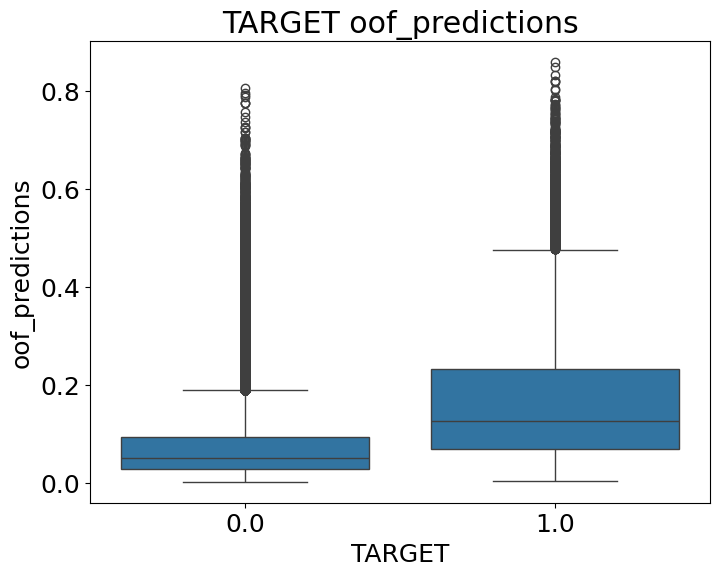

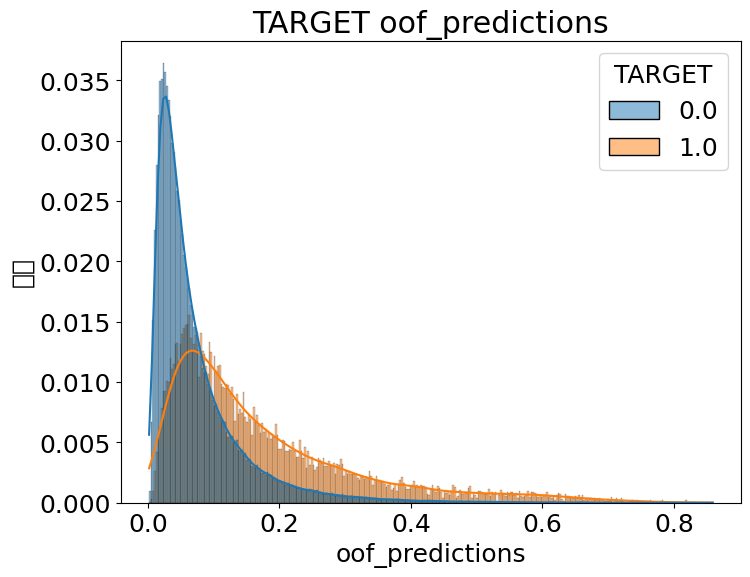

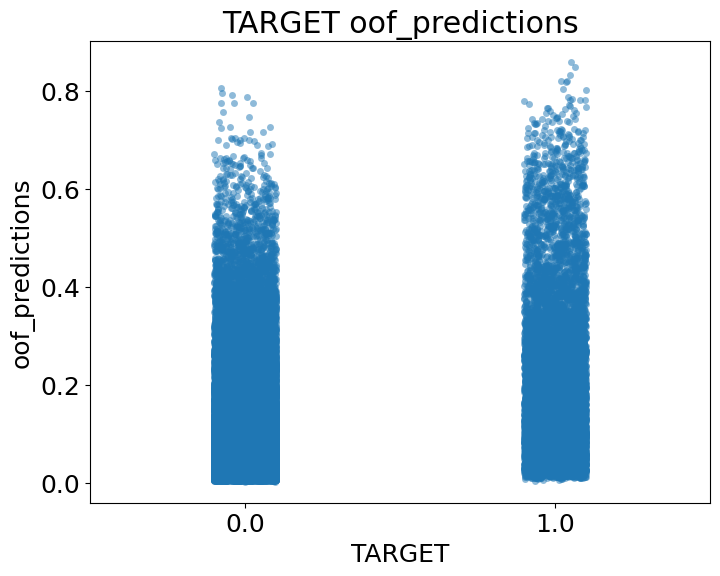

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# 可視化1: TARGETごとのoof_predictions分布を箱ひげ図で可視化
plt.figure(figsize=(8, 6))
sns.boxplot(x='TARGET', y='oof_predictions', data=train)
plt.title('TARGET oof_predictions')
plt.xlabel('TARGET')
plt.ylabel('oof_predictions')
plt.show()

# 可視化2: TARGETごとのoof_predictions分布をヒストグラム＋カーネル密度推定で可視化
plt.figure(figsize=(8, 6))
sns.histplot(data=train, x='oof_predictions', hue='TARGET', kde=True, stat='probability', common_norm=False)
plt.title('TARGET oof_predictions')
plt.xlabel('oof_predictions')
plt.ylabel('割合')
plt.show()

# 可視化3: TARGETとoof_predictionsの相関を散布図で可視化（分類だと情報量は少ないが例示）
# ※TARGETが0/1の二値であれば、x軸はoof_predictionsでy軸はTARGETで散布は限定的だが、傾向を見る参考になる
plt.figure(figsize=(8, 6))
sns.stripplot(x='TARGET', y='oof_predictions', data=train, jitter=True, alpha=0.5)
plt.title('TARGET oof_predictions')
plt.xlabel('TARGET')
plt.ylabel('oof_predictions')
plt.show()
